In [555]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from skimage.io import ImageCollection
from skimage.data import imread
from skimage.color import rgb2hsv, rgb2gray, gray2rgb
from skimage.transform import warp, SimilarityTransform, AffineTransform, ProjectiveTransform
from skimage.feature import (ORB, match_descriptors, corner_harris,
                             plot_matches)
from skimage.measure import ransac
from numpy.random import randint
from skimage.measure import label
from skimage.graph import route_through_array
from sklearn.feature_extraction import image

%matplotlib inline

In [556]:
def hsv_imread(img_path):
    return rgb2hsv(imread(img_path))[:,:,2]

def gray_imread(img_path):
    return rgb2gray(imread(img_path))

def load_images(search_dir, ftype):
    orb = ORB(n_keypoints=num_keypoints, fast_threshold=0.05)
    search_path = os.path.join(search_dir, '*'+ftype)
    files = glob(search_path)
    imgs = []
    for ff in files:
        img = hsv_imread(ff)
        k, d = detect_and_extract(orb, img)
        imgs.append({'name':os.path.split(ff)[1], 'img':img, 
                    'keypoints':k, 'descriptors':d})
        
        
    #imgs = ImageCollection(search_path, conserve_memory=False,
    #                       load_func=gray_imread)
    return imgs

In [557]:
pano_imgs = ImageCollection('*.jpg')
img_col = load_images('../data/jpg/', 'jpg')
img_feat = {}
num_imgs = len(img_col)
min_matches = 40
num_keypoints = 800

In [558]:
def compare(*images, **kwargs):
    """
    Function to display images side by side (from skimage example)

    Parameters
    ----------
    image0, image1, ....: ndarray
        Images to display
    labels: list
        Labels for the different images
    """
    f, ax = plt.subplots(1, len(images), **kwargs)
    ax = np.array(ax, ndmin=1)

    labels = kwargs.pop('labels', None)
    labels = [''] * len(images)
    for n, (image, label) in enumerate(zip(images, labels)):
        ax[n].imshow(image, interpolation='nearest', cmap=plt.gray())
        ax[n].set_title(label)
        #ax[n].axis('off')
    plt.tight_layout()

In [559]:
def get_best_matches(k1, k2, matches):
    src = k1[matches[:,0]][:,::-1]
    dst = k2[matches[:,1]][:,::-1]
    # if there are not enough matches, this fails
    model_robust, inliers = ransac((src, dst), ProjectiveTransform,
                                   min_samples=20, residual_threshold=1,
                                   max_trials=40)

    return model_robust, inliers

def develop_metadata_mosaic():
    # set max pitch and roll angles as qulity
    pass

In [560]:



def plot_two_matches(img1, img2, k1, k2, matches):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    plt.gray()
    #plot_matches(ax, img1, img2, k1, k2, matches)
    ax[0].imshow(img1)
    ax[0].axis('off')
    ax[0].scatter(k1[:, 1], k1[:, 0],  facecolors='none', edgecolors='r')

    ax[1].imshow(img2)
    ax[1].axis('off')
    ax[1].scatter(k2[:, 1], k2[:, 0], facecolors='none', edgecolors='r')
    plt.show()
    
    plt.show()
    
def plot_two_keypoints(img1, img2, k1, k2, s1=1, s2=1):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    plt.gray()

    ax[0].imshow(img1)
    ax[0].axis('off')
    ax[0].scatter(k1[:, 1], k1[:, 0], facecolors='none', edgecolors='r')

    ax[1].imshow(img2)
    ax[1].axis('off')
    ax[1].scatter(k2[:, 1], k2[:, 0], facecolors='none', edgecolors='r')
    plt.show()

In [610]:

def generate_costs(diff_image, mask, vertical=True, gradient_cutoff=2.):
    """
    Ensures equal-cost paths from edges to region of interest.
    
    Parameters
    ----------
    diff_image : ndarray of floats
        Difference of two overlapping images.
    mask : ndarray of bools
        Mask representing the region of interest in ``diff_image``.
    vertical : bool
        Control operation orientation.
    gradient_cutoff : float
        Controls how far out of parallel lines can be to edges before
        correction is terminated. The default (2.) is good for most cases.
        
    Returns
    -------
    costs_arr : ndarray of floats
        Adjusted costs array, ready for use.
    """
    if vertical is not True:
        return tweak_costs(diff_image.T, mask.T, vertical=vertical,
                           gradient_cutoff=gradient_cutoff).T
    
    # Start with a high-cost array of 1's
    costs_arr = np.ones_like(diff_image)
    
    # Obtain extent of overlap
    row, col = mask.nonzero()
    cmin = col.min()
    cmax = col.max()

    # Label discrete regions
    cslice = slice(cmin, cmax + 1)
    labels = label(mask[:, cslice])
    
    # Find distance from edge to region
    upper = (labels == 0).sum(axis=0)
    lower = (labels == 2).sum(axis=0)
    
    # Reject areas of high change
    ugood = np.abs(np.gradient(upper)) < gradient_cutoff
    lgood = np.abs(np.gradient(lower)) < gradient_cutoff
    
    # Give areas slightly farther from edge a cost break
    costs_upper = np.ones_like(upper, dtype=np.float64)
    costs_lower = np.ones_like(lower, dtype=np.float64)
    costs_upper[ugood] = upper.min() / np.maximum(upper[ugood], 1)
    costs_lower[lgood] = lower.min() / np.maximum(lower[lgood], 1)
    
    # Expand from 1d back to 2d
    vdist = mask.shape[0]
    costs_upper = costs_upper[np.newaxis, :].repeat(vdist, axis=0)
    costs_lower = costs_lower[np.newaxis, :].repeat(vdist, axis=0)
    
    # Place these in output array
    costs_arr[:, cslice] = costs_upper * (labels == 0)
    costs_arr[:, cslice] +=  costs_lower * (labels == 2)
    
    # Finally, place the difference image
    costs_arr[mask] = diff_image[mask]
    
    return costs_arr

In [ ]:
def calc_enblend(timg)

In [611]:
def add_alpha(img, mask=None):
    """
    Adds a masked alpha channel to an image.
    
    Parameters
    ----------
    img : (M, N[, 3]) ndarray
        Image data, should be rank-2 or rank-3 with RGB channels
    mask : (M, N[, 3]) ndarray, optional
        Mask to be applied. If None, the alpha channel is added
        with full opacity assumed (1) at all locations.
    """
    if mask is None:
        mask = np.ones_like(img)
        
    if img.ndim == 2:
        img = gray2rgb(img)
    
    return np.dstack((img, mask))

In [612]:
def simple_merge(base_warped, img_warped, base_mask, img_mask):
    
    # Add the three images together. This could create dtype overflows!
    # We know they are are floating point images after warping, so it's OK.
    merged = (base_warped + img_warped)

    # Track the overlap by adding the masks together
    # Multiply by 1.0 for bool -> float conversion
    overlap = (base_mask * 1.0 + img_mask)

    # Normalize through division by `overlap` - but ensure the minimum is 1
    norm = merged / np.maximum(overlap, 1)

    return norm

In [613]:
def find_mask(base_img, img, model_robust):
    # what type of interpolation
    # 0: nearest-neighbor
    # 1: bi-linear
    warp_order = 1
    output_shape, corner_min = find_output_shape(base_img, model_robust)
    #print("output_shape", output_shape, corner_min)
    #print(model_robust.scale, model_robust.translation, model_robust.rotation)
    
    # This in-plane offset is the only necessary transformation for the base image
    offset = SimilarityTransform(translation= -corner_min)
    base_warped = warp(base_img, offset.inverse, order=warp_order, 
                      output_shape = output_shape, cval=-1)
    
    # warp image corners to new position in mosaic
    transform = (model_robust + offset).inverse
    
    img_warped = warp(img, transform, order=warp_order, 
                      output_shape=output_shape, cval=-1)
    
    base_mask = (base_warped != -1)
    base_warped[~base_mask] = 0

    img_mask = (img_warped != -1)
    img_warped[~img_mask] = 0
    
    #merged_img = simple_merge(base_warped, img_warped, base_mask, img_mask)
    merged_img = minimum_cost_merge(base_warped, img_warped, base_mask, img_mask)
    merged_edges = remove_empty_edges(merged_img)
    return merged_edges
    

In [614]:
def detect_and_extract(detector, img):
    detector.detect_and_extract(img)
    keypoints = detector.keypoints
    descriptors = detector.descriptors
    return keypoints, descriptors

In [615]:
def find_output_shape(base_img, model_robust):
    r, c = base_img.shape[:2]
    
    corners = np.array([[0,0], 
                        [0,r],
                        [c,0],
                        [c,r]])
    
    warped_corners = model_robust(corners)
    all_corners = np.vstack((warped_corners, corners))
    # The overally output shape will be max - min
    corner_min = np.min(all_corners, axis=0)
    corner_max = np.max(all_corners, axis=0)
    output_shape = (corner_max - corner_min)
    # Ensure integer shape with np.ceil and dtype conversion
    output_shape = np.ceil(output_shape[::-1]).astype(int)
    return output_shape, corner_min


In [616]:
def find_two_matches(base_img, img, base_k, img_k, base_d, img_d, min_matches=10):
    matches = match_descriptors(base_d, img_d, cross_check=True)
    
    #   * src (image to be registered): pano2
    #   * dst (reference image): pano1, our middle frame registration target
    src = img_k[matches[:,1]][:,::-1]
    dst = base_k[matches[:,0]][:,::-1]
    
    # if there are not enough matches, this fails
    # TODO: what type of transform:
    # AffineTransform
    # SimilarityTransform
    # ProjectiveTransform
    if matches.shape[0] > min_matches:
        model_robust, inliers = ransac((src, dst), AffineTransform,
                                   min_samples=4, residual_threshold=1,
                                   max_trials=300)

        ransac_matches = matches[inliers]
        return model_robust, ransac_matches
    else:
        return np.zeros((0, 2)), np.zeros((0, 2))

In [617]:
sums = [1,0,0,0]

 

In [618]:
def remove_empty_edges(img):
    def get_mask(sums):
        if sum(sums) > 0:
            first = sums.index(1)
            last = sums[::-1].index(1)

            num_ones = (len(sums)-first)-last
            out = [0]*first + [1]*num_ones + [0]*last
            return out
        else:
            return sums
    
    #for ax in range(len(img.shape)):
    axes = [0, 1]
    for ax in range(2):
        sums = np.sum(img, axis=axes[ax])
        # make a mask of zero lines in image 
        sums= [bool(x) for x in sums]
        empty = get_mask(list(sums)) 
        img = np.compress(empty, img, axis=axes[ax-1])
    return img

In [570]:
def find_all_matches(unmatched, 
                     matched, 
                     num_keypoints=800,
                     min_to_match=10):
    num_unmatched = len(unmatched)
    if num_unmatched == 0:
        return unmatched, matched
    if num_unmatched == 1:
        matched.append(unmatched[0])
        return [], matched
    
    print("=====================================")
    base = unmatched[0]
    base_img = base['img']
    orb = ORB(n_keypoints=num_keypoints, fast_threshold=0.05)

    base_unmatched = []
    fail_limit = 3
    base_matched = 0
    base_name = base['name'].split('.')[0]
    
    for xx, timg in enumerate(unmatched[1:]):
        img = timg['img']
        
        print('working on xx', xx, base_name, timg['name'])
        base_k, base_d = detect_and_extract(orb, base_img)
        # if we haven't recorded the keypoints for this image, get them now
        if 'keypoints' in timg.keys():
            img_k = timg['keypoints']
            img_d = timg['descriptors']
        else:
            img_k, img_d = detect_and_extract(orb, img)
            timg['keypoints'] = img_k
            timg['descriptors'] = img_d

        
        matches = match_descriptors(base_d, img_d, cross_check=True)
        
        model_robust, ransac_matches = find_two_matches(base_img, img, 
                                                            base_k, img_k, 
                                                            base_d, img_d)
        if 0:
            fig, ax = plt.subplots(1,1,figsize=(15,12))
            plt.title('%s %s' %(bn, timg['name']))
            plot_matches(ax, base_img, img, base_k, img_k, matches)
        if ransac_matches.shape[0] < min_to_match:
            #print("not matched ransac shape", ransac_matches.shape[0])
            base_unmatched.append(timg)
            print("failed")
            if len(base_unmatched) > fail_limit:
                print('failing this')
                base_unmatched.extend(unmatched[xx+1:])
                break
        else:
            #print('ransac matches', ransac_matches.shape)
            base_img = find_mask(base_img, img, model_robust) 
            base_matched += 1
            base_name+= '_' + timg['name'].split('.')[0]
            

    # if we were able to match some images to this base_img that
    # were not matched in the last run, call again until 
    # the number of unmatched images stops decreasing
    
    #print('num previous unmatched', num_unmatched)
    #print("could not match %s out of %s imgs" %(len(base_unmatched), 
    #                                            len(unmatched)-1))
    # not_matched must be > 0
    # the new number of matches must be less than last time's not matched
    
    rr = {'name':base_name, 'img':base_img}
    if (len(base_unmatched)) > 0:
        if base_matched > 0 :
            base_unmatched.insert(0, rr)
            #print("!!!!!!!!!!! 1 match %s, unmatch %s" %(len(matched), len(base_unmatched)))
            
            return find_all_matches(base_unmatched, matched)
        else:
            matched.append(rr)
            #print("!!!!!!!!!!! 2 match %s, unmatch %s" %(len(matched), len(base_unmatched)))
            return find_all_matches(base_unmatched, matched)
    else:
        matched.append(rr)
        #print("!!!!!!!!!!! 3 match %s, unmatch %s" %(len(matched), len(base_unmatched)))
        return base_unmatched, matched
    

In [607]:
def minimum_cost_merge(base_warped, img_warped, base_mask, img_mask):
    # Start with the absolute value of the difference image.
    # np.abs is necessary because we don't want negative costs!
    costs = generate_costs(np.abs(img_warped - base_warped),
                           img_mask & base_mask)
    costs[0,  :] = 0
    costs[-1, :] = 0

    output_shape = base_warped.shape
    # Arguments are:
    #   cost array
    #   start pt
    #   end pt
    #   can it traverse diagonally
    ymax = output_shape[1] - 1
    xmax = output_shape[0] - 1

    # Start anywhere along the top and bottom, left of center.
    mask_pts01 = [[0,    ymax // 3],
                  [xmax, ymax // 3]]

    # Start anywhere along the top and bottom, right of center.
    mask_pts12 = [[0,    2*ymax // 3],
                  [xmax, 2*ymax // 3]]
    
    pts, _ = route_through_array(costs, mask_pts01[0], mask_pts01[1], fully_connected=True)

    # Convert list of lists to 2d coordinate array for easier indexing
    pts = np.array(pts)
   
    # Start with an array of zeros and place the path
    _img_mask = np.zeros_like(img_warped, dtype=np.uint8)
    _img_mask[pts[:, 0], pts[:, 1]] = 1


    # Labeling starts with zero at point (0, 0)
    _img_mask[label(_img_mask, connectivity=1) == 0] = 1
    
    _base_mask = ~(_img_mask).astype(bool)

    base_color = gray2rgb(base_warped)
    img_color = gray2rgb(img_warped)
    base_final = add_alpha(base_warped, _base_mask)
    img_final = add_alpha(img_warped, _img_mask)
    
    # Start with empty image
    base_combined = np.zeros_like(base_warped)
    
    base_combined += base_warped * _base_mask
    base_combined += img_warped * _img_mask
    
    return base_combined



   

In [608]:
def patchmaker(img):
    patches = image.extract_patches_2d(img, patch_size=(100,100),
                                         max_patches=10,
                                         random_state=182)
    return patches

working on xx 0 IMG_1765 IMG_1766.jpg
working on xx 1 IMG_1765_IMG_1766 IMG_1767.jpg
working on xx 2 IMG_1765_IMG_1766_IMG_1767 IMG_1768.jpg
working on xx 3 IMG_1765_IMG_1766_IMG_1767_IMG_1768 IMG_1769.jpg
working on xx 4 IMG_1765_IMG_1766_IMG_1767_IMG_1768_IMG_1769 IMG_1770.jpg
failed
working on xx 5 IMG_1765_IMG_1766_IMG_1767_IMG_1768_IMG_1769 IMG_1771.jpg
failed
working on xx 6 IMG_1765_IMG_1766_IMG_1767_IMG_1768_IMG_1769 IMG_1772.jpg
failed
working on xx 7 IMG_1765_IMG_1766_IMG_1767_IMG_1768_IMG_1769 IMG_1773.jpg
failed
failing this
working on xx 0 IMG_1765_IMG_1766_IMG_1767_IMG_1768_IMG_1769 IMG_1770.jpg
failed
working on xx 1 IMG_1765_IMG_1766_IMG_1767_IMG_1768_IMG_1769 IMG_1771.jpg
failed
working on xx 2 IMG_1765_IMG_1766_IMG_1767_IMG_1768_IMG_1769 IMG_1772.jpg
failed
working on xx 3 IMG_1765_IMG_1766_IMG_1767_IMG_1768_IMG_1769 IMG_1773.jpg
failed
failing this
working on xx 0 IMG_1770 IMG_1771.jpg
working on xx 1 IMG_1770_IMG_1771 IMG_1772.jpg
working on xx 2 IMG_1770_IMG_1771_I

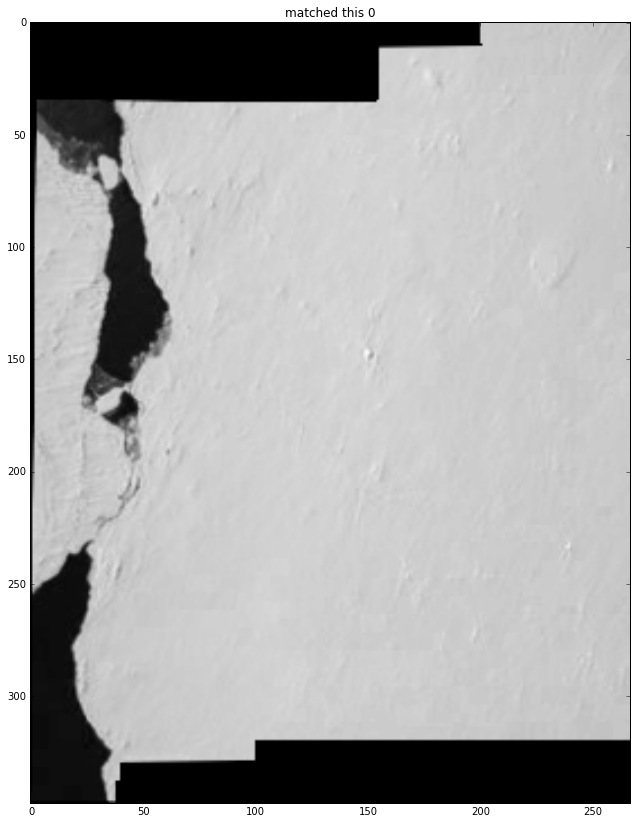

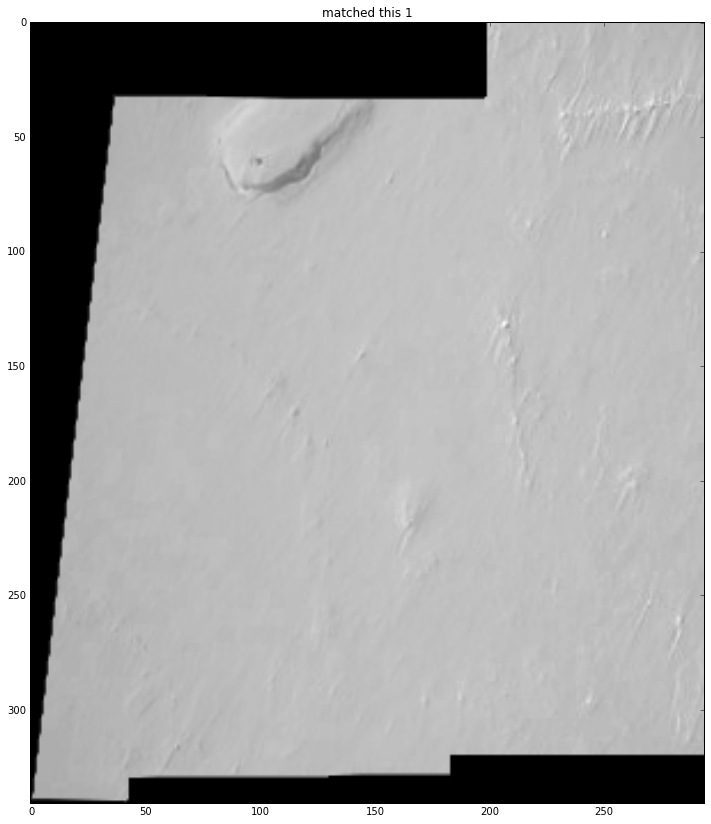

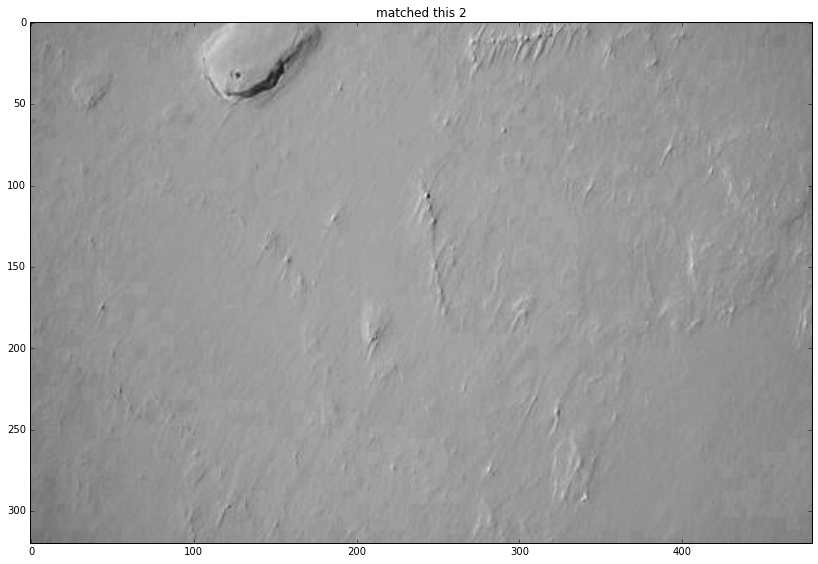

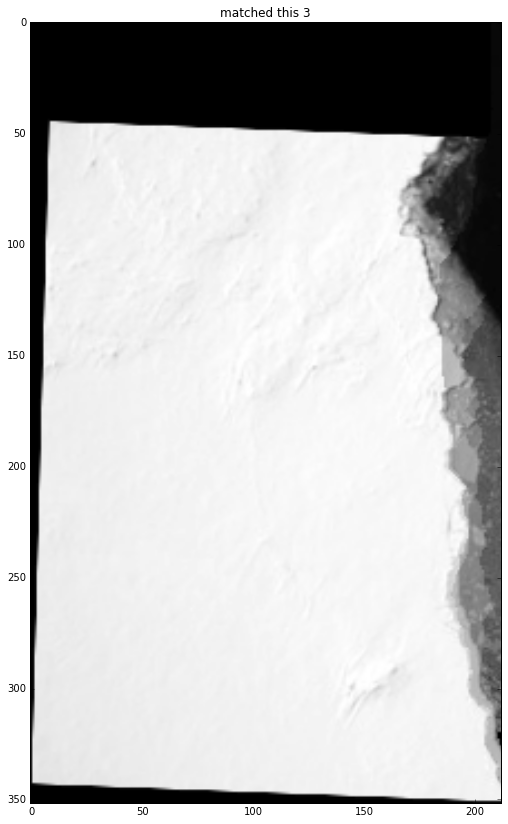

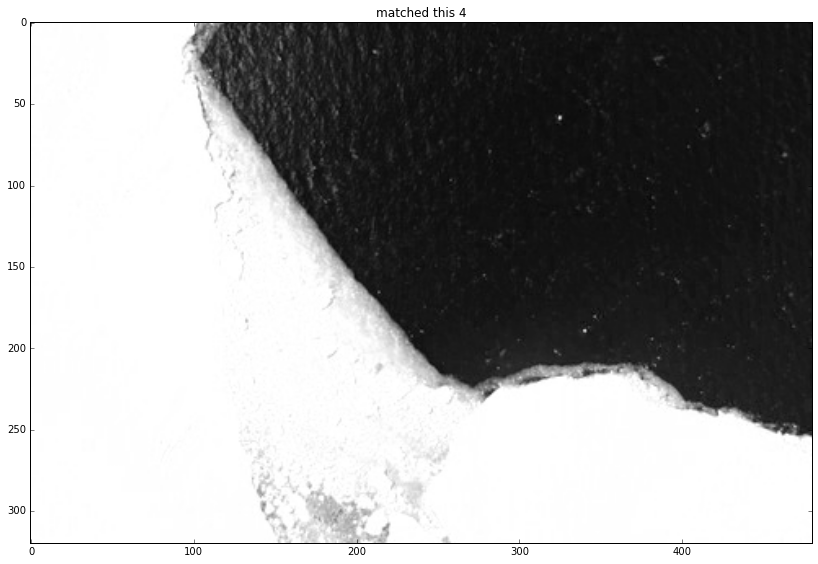

In [619]:
#patches = patchmaker(img_col[0])
base_img = img_col[0]['img']

timg_col = img_col[:18]

#dbase_img, dimgs = find_all_matches(base_img, timg_col, len(timg_col))
unmatched, mymatched = find_all_matches(timg_col, [])

for xx, timg in enumerate(mymatched):
    plt.figure(figsize=(14,14))
    plt.title("matched this %s" %xx)
    plt.imshow(timg['img'])
    plt.show()
    


5
working on xx 0 IMG_1765_IMG_1766_IMG_1767_IMG_1768_IMG_1769 IMG_1770_IMG_1771_IMG_1772_IMG_1773_IMG_1773_IMG_1774
failed
working on xx 1 IMG_1765_IMG_1766_IMG_1767_IMG_1768_IMG_1769 IMG_1773
failed
working on xx 2 IMG_1765_IMG_1766_IMG_1767_IMG_1768_IMG_1769 IMG_1775_IMG_1776_IMG_1777_IMG_1777_IMG_1777_IMG_1777_IMG_1778_IMG_1779_IMG_1780_IMG_1781
failed
working on xx 3 IMG_1765_IMG_1766_IMG_1767_IMG_1768_IMG_1769 IMG_1782.jpg
failed
failing this
working on xx 0 IMG_1770_IMG_1771_IMG_1772_IMG_1773_IMG_1773_IMG_1774 IMG_1773
working on xx 1 IMG_1770_IMG_1771_IMG_1772_IMG_1773_IMG_1773_IMG_1774_IMG_1773 IMG_1775_IMG_1776_IMG_1777_IMG_1777_IMG_1777_IMG_1777_IMG_1778_IMG_1779_IMG_1780_IMG_1781
failed
working on xx 2 IMG_1770_IMG_1771_IMG_1772_IMG_1773_IMG_1773_IMG_1774_IMG_1773 IMG_1782.jpg
failed
working on xx 3 IMG_1770_IMG_1771_IMG_1772_IMG_1773_IMG_1773_IMG_1774_IMG_1773 IMG_1782.jpg
failed
working on xx 0 IMG_1770_IMG_1771_IMG_1772_IMG_1773_IMG_1773_IMG_1774_IMG_1773 IMG_1775_IMG_17

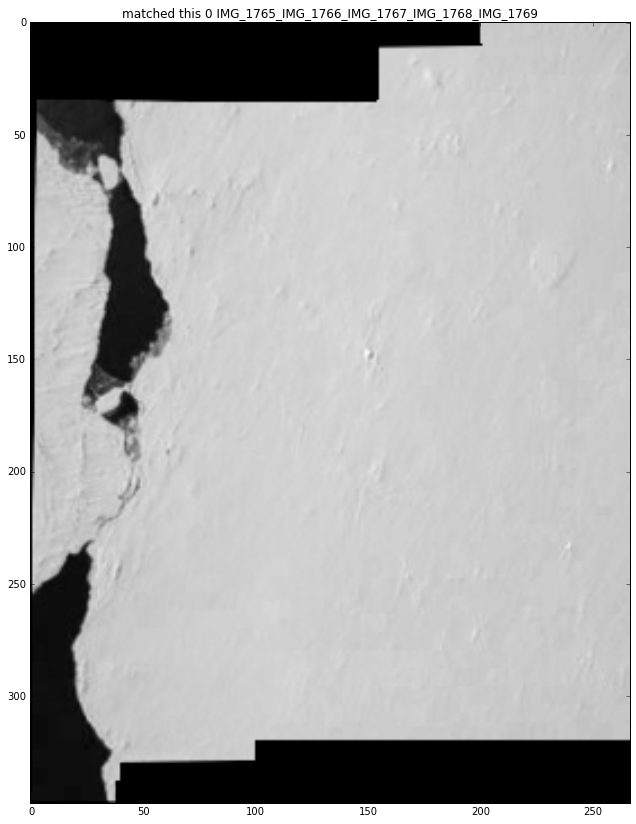

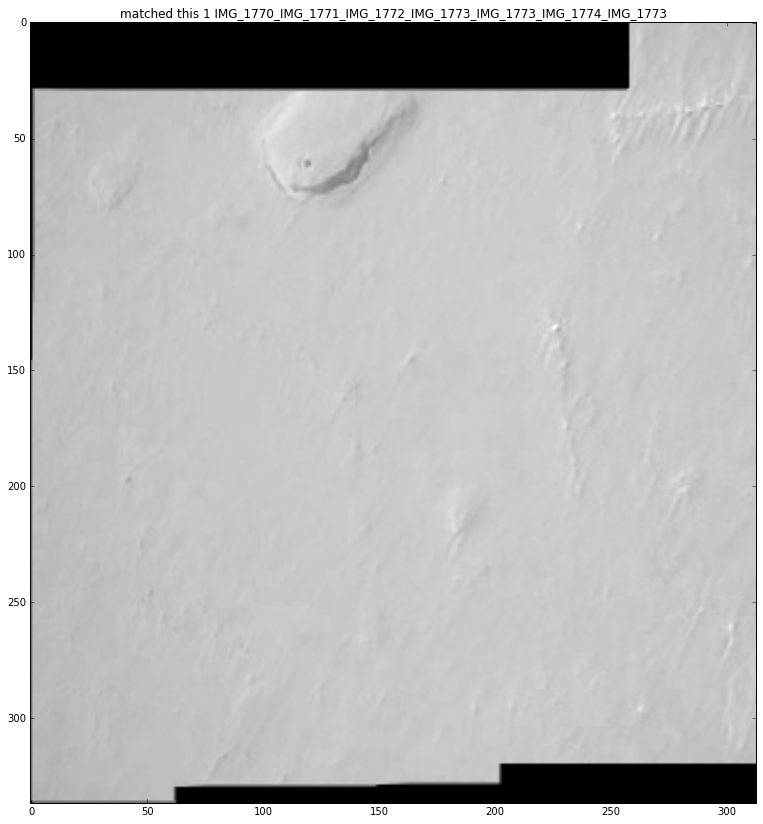

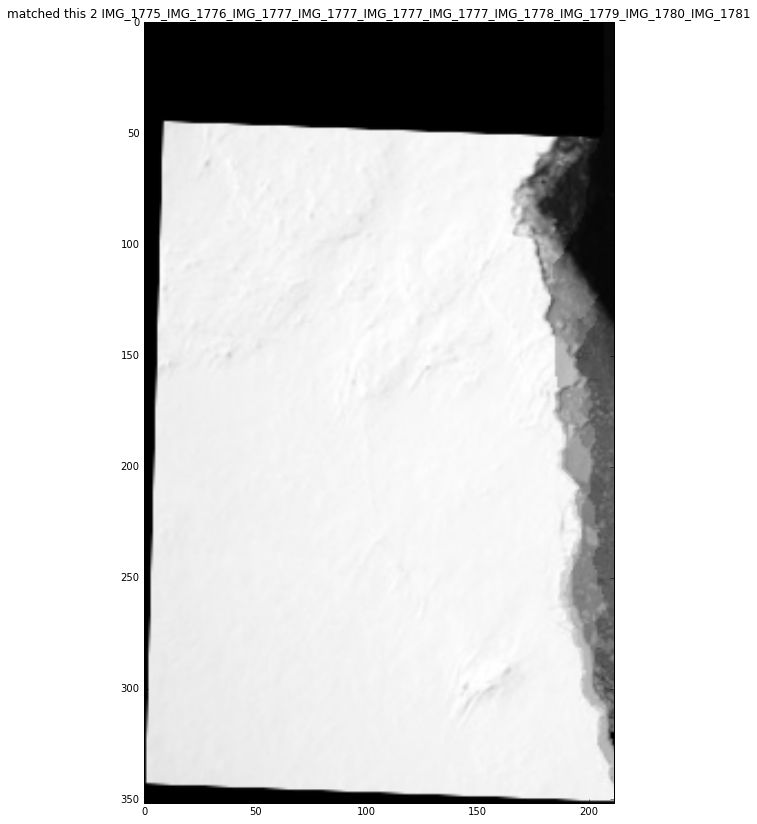

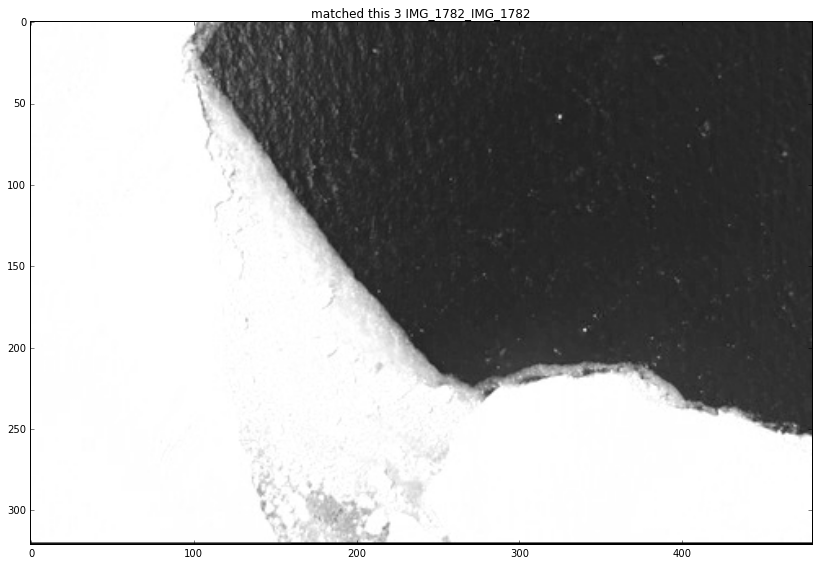

In [622]:
print(len(mymatched))
#print(unmatched)
unm2, mymatched2 = find_all_matches(mymatched, [])
#print("THIS", mymatched2)
print("NEXT", len(mymatched2))
for xx, timg in enumerate(mymatched2):
    plt.figure(figsize=(14,14))
    plt.title("matched this %s %s" %(xx, timg['name']))
    plt.imshow(timg['img'])
    plt.show()

In [ ]:
t1 = (0,-150)
t2 = (-150,-300)
t3 = (0, 200)
t4 = (150, 0)
t5 = (300, 300)
base_img = rgb2gray(pano_imgs[0])
imgs = []
ts = [t1, t2, t2, t4, t5]

#for tt in ts:
#    tform = SimilarityTransform(translation=tt)
#    imgs.append(warp(base_img, tform))

#dbase_img, dimgs = find_all_matches(base_img, imgs, len(imgs), 50)
#plt.figure()
#plt.imshow(dbase_img)
#plt.show()


In [ ]:
#run through each of the images starting randomly

for x in range(4):
    imgs = [{'img':rgb2gray(pano_imgs[0])},
            {'img':rgb2gray(pano_imgs[1])}, 
            {'img':rgb2gray(pano_imgs[2])}]
    base_x = randint(0, len(imgs))
    base_img = imgs.pop(base_x)['img']
    print("RUNNING BASE X", base_x)
    dbase_img, dimgs = find_all_matches(base_img, imgs, len(imgs))

    
    # if there are still images left over, use these to 
    # start a new base image
    print('finished with %s unmatched' %len(dimgs))

    plt.figure()
    plt.title('base x %s' %base_x)
    plt.imshow(dbase_img)
    plt.show()


In [ ]:



    

    

## Match descriptors between left/right images and the center
#matches10 = match_descriptors(base_d, d0, cross_check=True)

#matches12 = match_descriptors(base_d, d2, cross_check=True)

#model_robust10, ransac_matches10 = find_two_matches(base_img, img0, base_k, k0, base_d, d0)
#model_robust12, ransac_matches12 = find_two_matches(base_img, img2, base_k, k2, base_d, d2)

#nn0 = find_mask(base_img, img0, model_robust10)
#plt.show()
#nn2 = find_mask(base_img, img2, model_robust12)
#plt.show()
#fig, ax = plt.subplots(1,1,figsize=(15,12))
#plot_matches(ax, base_img, img2, base_k, k2, ransac_matches)

